# Lecture de la base de donnée

La base de donnée sera lue à partir d'un fichier csv correspondant en terme de structure à [example.csv](example.csv). <br>
Ce fichier contient trois colonnes : fichier csv contenant le chromatograme, etat normal(1) ou non(0), label : description.

Comme dans [readData.ipynb](readData.ipynb), on importe les modules utiles.

In [193]:
import pandas as pd
import tools
from importlib import reload
reload(tools)

pd.options.plotting.backend = "plotly"

On spécifie le chemin du fichier dans lequel est stocké la base de donnée dans la variable `FILE`, et le chemin jusqu'aux chromatogrammes mentionnés dans la base de donnée dans la variable : `PATH`. <br>

In [194]:
FILE = "../data/database-verified.csv"
PATH = "../data/data-IA/"

On met les informations de la base de donnée dans un DataFrame (`db`), dans lequel on remplacera les 1 et 0 dans la colonne `normal` par respectivement `True` et `False` si besoin dans la suite du traitement.

In [195]:
db = pd.read_csv(FILE)
print(db)

                    file  status  \
0        aafifl-20190313       1   
1        aafify-20190313       0   
2    abdirahman-20190608       1   
3    abdirahman-20190611       1   
4     abuladzeq-20190912       0   
..                   ...     ...   
562   yverneaus-20190513       1   
563  zincirsult-20190424       0   
564     zincish-20190911       0   
565    zitounia-20190429       0   
566    zitounia-20190909       0   

                                                 label label_num  
0    Pas d'évidence de trouble d'ordre métabolique ...         0  
1    methyl glutarique et methyl glutaconique acidu...         2  
2    Pas d'évidence de trouble d'ordre métabolique ...         0  
3    Pas d'évidence de trouble d'ordre métabolique ...         0  
4    Pas d'évidence de trouble d'ordre métabolique ...         4  
..                                                 ...       ...  
562  Pas d'évidence de trouble d'ordre métabolique ...         0  
563                            

In [196]:
# vérification qu'il n'y a pas d'erreur
temp = db[~db["status"].isin([0,1])]
print(temp.head())
temp = db[(db['status'] == 1) & (db['label_num'] != '0')]
print(temp)
temp = db[(db['status'] == 0) & (db['label_num'] == '0')]
print(temp)

Empty DataFrame
Columns: [file, status, label, label_num]
Index: []
                 file  status  \
545  wagnerc-20190930       1   

                                                 label label_num  
545  Pas d'évidence de trouble d'ordre métabolique ...       NaN  
Empty DataFrame
Columns: [file, status, label, label_num]
Index: []


Ensuite plutôt que d'avoir uniquement le nom des chromatogrammes, on peut récupérer les courbes traitées avec la fonction `readListOfData`.

In [197]:
db['chromato'] = tools.readListOfData(db['file'], PATH)
print(db)

Problème de taille sur le chromatogramme
Erreur de détection du pic de référence, fichier : tabanik-20191202
                    file  status  \
0        aafifl-20190313       1   
1        aafify-20190313       0   
2    abdirahman-20190608       1   
3    abdirahman-20190611       1   
4     abuladzeq-20190912       0   
..                   ...     ...   
562   yverneaus-20190513       1   
563  zincirsult-20190424       0   
564     zincish-20190911       0   
565    zitounia-20190429       0   
566    zitounia-20190909       0   

                                                 label label_num  \
0    Pas d'évidence de trouble d'ordre métabolique ...         0   
1    methyl glutarique et methyl glutaconique acidu...         2   
2    Pas d'évidence de trouble d'ordre métabolique ...         0   
3    Pas d'évidence de trouble d'ordre métabolique ...         0   
4    Pas d'évidence de trouble d'ordre métabolique ...         4   
..                                                

In [198]:
db['chromato'][0].df.plot()

Sélection des colonnes pour l'entrainement du réseau (dans le cas normal/non normal)

In [199]:
db.loc[:, ['chromato', 'status']]

,chromato,status
0,<tools.Data object at 0x000002775E5AEB50>,1
1,<tools.Data object at 0x000002775C24BFD0>,0
2,<tools.Data object at 0x000002775BC60700>,1
3,<tools.Data object at 0x000002775E5D3FA0>,1
4,<tools.Data object at 0x000002775C188CA0>,0
...,...,...
562,<tools.Data object at 0x000002775BD00F40>,1
563,<tools.Data object at 0x000002775BD008E0>,0
564,<tools.Data object at 0x000002775BD007C0>,0
565,<tools.Data object at 0x000002775BD00F70>,0


Exemple de données sous forme de matrice pour l'utilisation en machine learning avec scikit-learn, et affichage du preier chromatogramme.

Nombre de données 567
En entrée : 
 [[0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 4.190541 0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]] 
En sortie :  [1 0 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0
 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0
 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1
 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 1
 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1
 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 

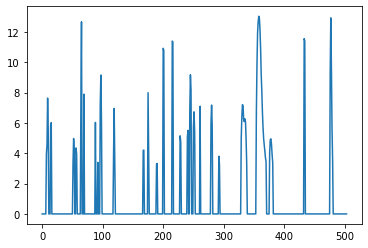

In [200]:
import matplotlib.pyplot as plt
reload(tools)
X, y = tools.getData(FILE, PATH)
print('Nombre de données', len(y))
print("En entrée : \n", X, "\nEn sortie : ", y)
plt.plot(X[0, :])
plt.show()